In [4]:
from google.colab import drive
drive.mount('/content/drive')

import re
import string
import copy

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sn
from scipy.sparse import hstack

%matplotlib inline

import spacy
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('wordnet')
stop = set(stopwords.words('english'))

from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score

import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import random_split, TensorDataset, DataLoader, random_split, RandomSampler, SequentialSampler
from joblib import dump, load

from wordcloud import WordCloud


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Define the device for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the functions to save and load models
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

def load_model(model, filepath, device):
    model.load_state_dict(torch.load(filepath, map_location=device))
    model.to(device)
    print(f"Model loaded from {filepath}")

## Feature Extraction (Question 1)

### Data Preparation and Cleaning

In [28]:
# Prepare the dataset
# Load the correct data (including 49973 pairs)
# Load train_stances.csv
stances = pd.read_csv("drive/MyDrive/fnc-1/train_stances.csv")
# Load train_bodies.csv
bodies = pd.read_csv("drive/MyDrive/fnc-1/train_bodies.csv")

# Merge the data into one df
df = stances.merge(bodies, on="Body ID", how="inner")
df = df[["Headline", "articleBody", "Stance"]]
#df = df.head(600)
# Use 10000 for the input
# df = df.sample(n=10000, random_state=411)

# df
# df.describe()
# df.info()
df.head()

,Headline,articleBody,Stance
0,Police find mass graves with at least '15 bodi...,Danny Boyle is directing the untitled film\r\n...,unrelated
1,Seth Rogen to Play Apple’s Steve Wozniak,Danny Boyle is directing the untitled film\r\n...,discuss
2,Mexico police find mass grave near site 43 stu...,Danny Boyle is directing the untitled film\r\n...,unrelated
3,Mexico Says Missing Students Not Found In Firs...,Danny Boyle is directing the untitled film\r\n...,unrelated
4,New iOS 8 bug can delete all of your iCloud do...,Danny Boyle is directing the untitled film\r\n...,unrelated


<Axes: >

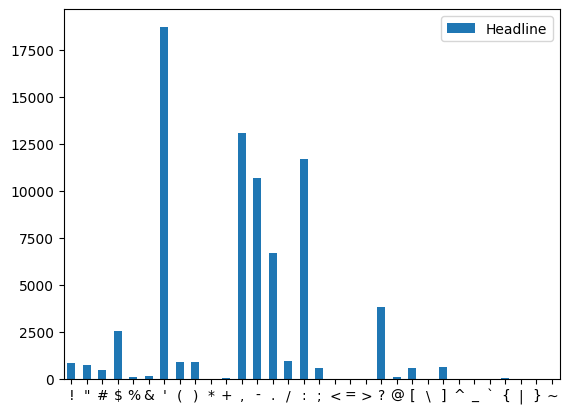

In [29]:
# Explore the data further before data cleaning
# Define the corpus' for visualisation
headline_corpus = df["Headline"].values
# body_corpus = df["articleBody"].values

# Store the punctuation count
special = [char for char in string.punctuation]
special_str = string.punctuation
punc_headline = np.zeros(len(special))
punc_body = np.zeros(len(special))

# Count the punctuation
for text in headline_corpus:
  for char in text:
    if char in special:
        punc_headline[special_str.find(char)] += 1

# for text in body_corpus:
#   for char in text:
#     if char in special:
#         punc_body[special_str.find(char)] += 1

# Plot the punctuation count
punc_plot = pd.DataFrame({"Headline": punc_headline}, index=special)
punc_plot.plot.bar(rot=0)

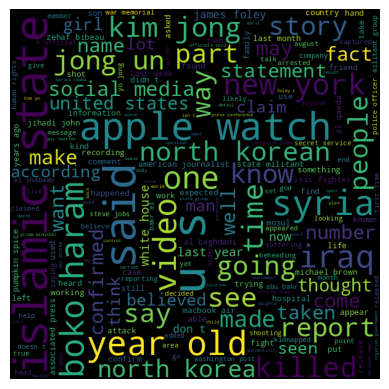

In [30]:
# Visualise the words in the df
def visualise(dataframe, index):
    words = ""
    for msg in dataframe[dataframe.columns[index]]:
        msg = msg.lower()
        words += msg + " "
    # Create a word cloud plot
    wordcloud = WordCloud(width=600, height=600).generate(words)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

visualise(df, 1)

In [6]:
# Perform data cleaning
# Remove noise based on exploratory analysis

# Convert all newline characters into spaces
def replace_lines(text):
  return text.replace("\n", " ")

# Separated hyphenated or separated words
def remove_apostrophe(text):
  return text.replace("'", "")

# Remove punctuation and replace with " " (to avoid concatenated words)
def replace_punct(text):
  table = str.maketrans(string.punctuation, " " * len(string.punctuation))
  return text.translate(table)

# Remove special characters
def remove_special(text):
  # Define the characters we should allow
  chars_ascii = string.ascii_letters + string.digits + " "
  table = str.maketrans('', '', ''.join(set(text) - set(chars_ascii)))
  return text.translate(table)

# Remove the multiple spaces
def remove_mult_space(text):
  return re.sub(" +", " ", text)

# Clean the columns
def clean_column(col):
  # Replace all newlines with spaces
  df[col] = df[col].apply(replace_lines)
  # Remove all apostrophes
  df[col] = df[col].apply(remove_apostrophe)
  # Replace all punctuation with spaces
  df[col] = df[col].apply(lambda x: replace_punct(x))
  # Remove all special characters
  df[col] = df[col].apply(lambda x: remove_special(x))
  # Convert all data into lowercase
  df[col] = df[col].str.lower()
  # Remove multiple spaces
  df[col] = df[col].str.lower()

# Clean the columns
clean_column("Headline")
clean_column("articleBody")

df

,Headline,articleBody,Stance
0,police find mass graves with at least 15 bodie...,danny boyle is directing the untitled film se...,unrelated
1,seth rogen to play apples steve wozniak,danny boyle is directing the untitled film se...,discuss
2,mexico police find mass grave near site 43 stu...,danny boyle is directing the untitled film se...,unrelated
3,mexico says missing students not found in firs...,danny boyle is directing the untitled film se...,unrelated
4,new ios 8 bug can delete all of your icloud do...,danny boyle is directing the untitled film se...,unrelated
...,...,...,...
49967,amazon is opening a brick and mortar store in ...,amazon the cyber store that sells everything ...,agree
49968,elon university has not banned the term freshm...,elon n c a recent rumor claims that elon un...,agree
49969,fake bbc news website set up to carry charlie ...,a realistic looking fake bbc news website has ...,agree
49970,apple was forced to nix key health features fr...,the health focused smartwatch that apple initi...,discuss


In [7]:
# Lemmatize the strings
spacy_nlp = spacy.load("en_core_web_sm")

def lemmatize(text):
  doc = spacy_nlp(text)
  return " ".join([token.lemma_ for token in doc])

In [8]:
# Apply the lemmatization
df["Headline"] = df["Headline"].apply(lemmatize)
df["articleBody"] = df["articleBody"].apply(lemmatize)

In [9]:
# Remove stopwords
def remove_stopwords(text):
  doc = spacy_nlp(text)
  filtered_sentence = [token.text for token in doc if not token.is_stop]
  return " ".join(filtered_sentence)

In [10]:
# Apply the remove stopwords process
df_stopwords = df.copy(deep=True)

df_stopwords["Headline"] = df_stopwords["Headline"].apply(remove_stopwords)
df_stopwords["articleBody"] = df_stopwords["articleBody"].apply(remove_stopwords)

In [11]:
# Save the current df
df.to_csv("drive/MyDrive/fnc-1/weights/df_lemma2.csv", index=False)
df_stopwords.to_csv("drive/MyDrive/fnc-1/weights/df_stopwords2.csv", index=False)

In [5]:
# Load the current dfs to continue training
df = pd.read_csv("drive/MyDrive/fnc-1/weights/df_lemma2.csv")
df_stopwords = pd.read_csv("drive/MyDrive/fnc-1/weights/df_stopwords2.csv")

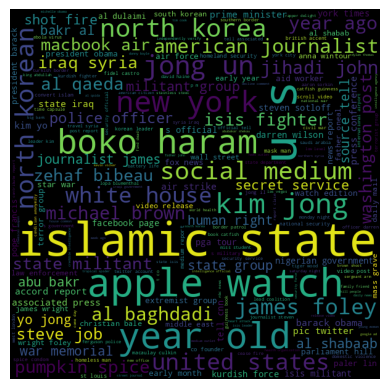

In [23]:
# Visualize the words in the df after processing
visualise(df_stopwords, 1)

In [13]:
# Normalize the stance categorical variable
# Agree = 0, Disagree = 1, Discuss = 2, Unrelated = 3
label_encoder = LabelEncoder()
df_stopwords["Stance"] = label_encoder.fit_transform(df_stopwords["Stance"])

### TF-IDF

In [14]:
# TF-IDF implementation
# Split the data into a training, validation and test set
df_tfidf = df_stopwords.copy(deep=True)

# Combine the headline and article body inputs
# Alternative method exists to create two TF-IDF for each input and then combine
df_tfidf["combined"] = df_tfidf["Headline"] + " " + df_tfidf["articleBody"]
x = df_tfidf["combined"]
y = df_tfidf["Stance"]

# Split into 70% training, 20% testing and 10% validation
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/3, random_state=4)

# Define the tfidf process. This tokenizes also
tfidf = TfidfVectorizer(decode_error="ignore", lowercase=True, min_df=2)

# Perform tfidf on the input data
all_tfidf = tfidf.fit_transform(x.values.astype("U"))
# val_tfidf = tfidf.transform(X_val.values.astype("U"))
# test_tfidf = tfidf.transform(X_test.values.astype("U"))

### BERT

In [15]:
# Transformer implementation
def BERT(dataframe):
  # Define the BERT tokenizer
  tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
  BERT = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)

  # Run on GPU if avaliable
  BERT.to(device)
  # Set the model to evaluation mode
  BERT.eval()

  # Convert data into lists
  headlines = dataframe["Headline"].tolist()
  bodies = dataframe["articleBody"].tolist()

  # Perform tokenization and create a single input
  encoded_inputs = tokenizer(
    headlines,
    bodies,
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512,
    add_special_tokens=True  # Add special tokens between merged input for BERT
  )

  # Extract the tokenized inputs and define the padding tokens to ignore
  input = encoded_inputs["input_ids"].to(device)
  attention_masks = encoded_inputs["attention_mask"].to(device)

  # Ensure the BERT features will be saved
  BERT_features = []
  # Not training BERT but instead performing a forward pass
  with torch.no_grad():
    for batch in DataLoader(TensorDataset(input, attention_masks), batch_size=16):
      # Add the batch to GPU
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask = batch

      # Perform the forward pass to return the hidden states
      outputs = BERT(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

      # The hidden state of the [CLS] token
      cls_hidden_state = outputs[2][0][:, 0, :].cpu().numpy()
      # Save the hidden states to our list
      BERT_features.append(cls_hidden_state)

  # Convert the list into a single array
  BERT_features = np.vstack(BERT_features)
  return BERT_features


In [ ]:
df_trans = df_stopwords.copy(deep=True)
BERT_features = BERT(df_trans)

In [17]:
# Save the BERT features
np.save("drive/MyDrive/fnc-1/weights/BERT_features2.npy", BERT_features)

In [18]:
# Load the BERT features to continue training
BERT_features = np.load("drive/MyDrive/fnc-1/weights/BERT_features2.npy")
df_trans = df_stopwords.copy(deep=True)

## Related/Unrelated Classification (Question 2a)

In [19]:
# Adjust our y stances in a new df, into related and unrelated for training
df_q2 = df_trans.copy(deep = True)

# Agree = 0, Disagree = 1, Discuss = 2, Unrelated = 3

# Adjust all stances to related (1)
def process_q2(stance):
  df_q2["Stance"] = df_q2["Stance"].replace(stance, 1)

process_q2(0)
process_q2(1)
process_q2(2)
# Adjust unrelated to 0
df_q2["Stance"] = df_q2["Stance"].replace(3, 0)

df_q2

# Unrelated = 0, Related = 1

,Headline,articleBody,Stance
0,police find mass grave 15 body near mexico tow...,danny boyle direct untitled film seth rogen...,0
1,seth rogen play apple steve wozniak,danny boyle direct untitled film seth rogen...,1
2,mexico police find mass grave near site 43 stu...,danny boyle direct untitled film seth rogen...,0
3,mexico miss student find mass grave,danny boyle direct untitled film seth rogen...,0
4,new io 8 bug delete icloud document,danny boyle direct untitled film seth rogen...,0
...,...,...,...
49967,amazon open brick mortar store manhattan,amazon cyber store sell plan open physic...,1
49968,elon university ban term freshman despite r...,elon n c recent rumor claim elon univer...,1
49969,fake bbc news website set carry charlie hebdo ...,realistic look fake bbc news website set carry...,1
49970,apple force nix key health feature smartwatch ...,health focus smartwatch apple initially envisi...,1


### Random Forest (Related or Unrelated) with BERT

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Number of Estimators: 10
Best Max Depth: None
Best Min Samples Split: 2 

Classification Report:
               precision    recall  f1-score   support

           0       0.73      1.00      0.85     10975
           1       0.00      0.00      0.00      4017

    accuracy                           0.73     14992
   macro avg       0.37      0.50      0.42     14992
weighted avg       0.54      0.73      0.62     14992

Confusion Matrix:
 [[10975     0]
 [ 4017     0]]
Accuracy: 0.7320570971184632


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


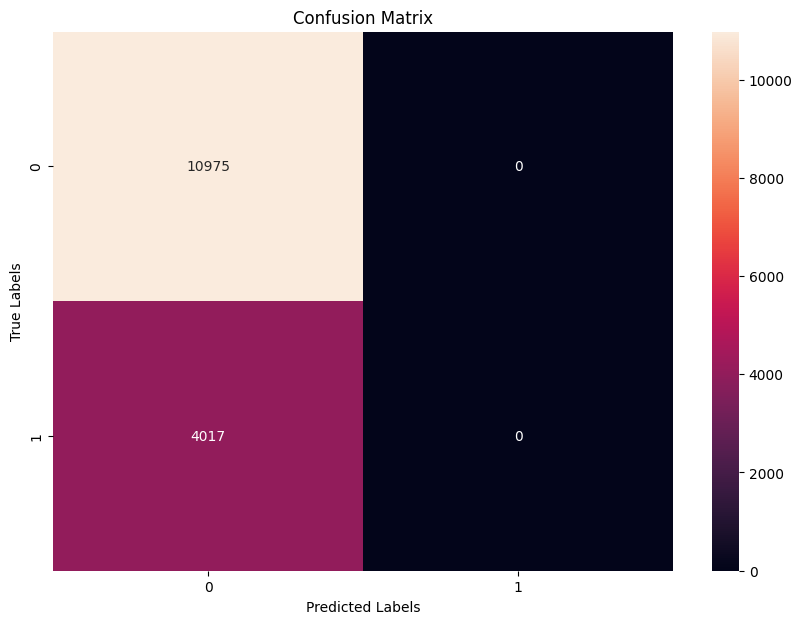

In [20]:
# ML model implementation
# Define x as the dataframe from TF-IDF or features from BERT
x_forest = BERT_features
y_forest = df_q2["Stance"]

# Split 70% for training, 20% for testing and 10% for validation
x_train, x_test, y_train, y_test = train_test_split(x_forest, y_forest, test_size=0.3, random_state=4)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1/3, random_state=4)

# Initialise the model
# pipeline = make_pipeline(StandardScaler(with_mean=False), PCA(), RandomForestClassifier())
pipeline = make_pipeline(StandardScaler(with_mean=False), RandomForestClassifier())

# Define the hyperparameter grid (for PCA and the forest classifier)
param_grid = {
  # "pca__n_components": range(2, min(8, x_train.shape[1]+1)),
  "randomforestclassifier__n_estimators": [10, 50, 100, 200],
  "randomforestclassifier__max_depth": [None, 10, 20],
  "randomforestclassifier__min_samples_split": [2, 5, 10]
}

# Use cross-validation for grid search
cv = StratifiedKFold(n_splits=5)
# Initialise the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring="accuracy", verbose=1)
# grid_search = load("drive/MyDrive/fnc-1/weights/forest_bert.joblib")

# Train the model
grid_search.fit(x_train, y_train)

# Save the model
dump(grid_search, "drive/MyDrive/fnc-1/weights/forest_bert2.joblib")

# Predict on the test set
y_pred = grid_search.predict(x_test)

# Print the best hyperparameter values
# print("Best PCA Dimension:", grid_search.best_params_["pca__n_components"])
print("Best Number of Estimators:", grid_search.best_params_["randomforestclassifier__n_estimators"])
print("Best Max Depth:", grid_search.best_params_["randomforestclassifier__max_depth"])
print("Best Min Samples Split:", grid_search.best_params_["randomforestclassifier__min_samples_split"], "\n")

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sn.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="g")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


### Random Forest (Related or Unrelated) with TF-IDF

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Number of Estimators: 200
Best Max Depth: None
Best Min Samples Split: 2 

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97     10975
           1       0.94      0.86      0.90      4017

    accuracy                           0.95     14992
   macro avg       0.95      0.92      0.93     14992
weighted avg       0.95      0.95      0.95     14992

Confusion Matrix:
 [[10772   203]
 [  550  3467]]
Accuracy: 0.949773212379936


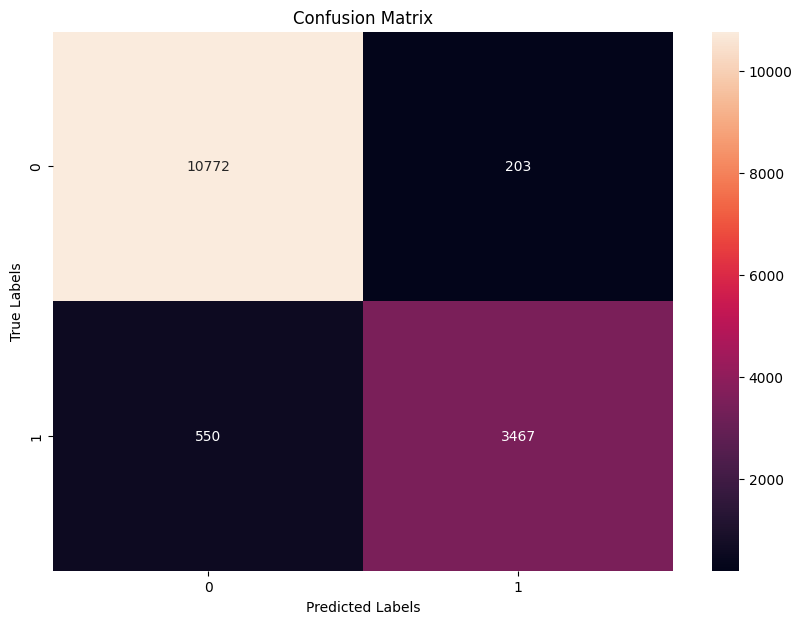

In [21]:
# ML model implementation
# Define x as the dataframe from TF-IDF or features from BERT
x_forest = all_tfidf
y_forest = df_q2["Stance"]

# Split 70% for training, 20% for testing and 10% for validation
x_train, x_test, y_train, y_test = train_test_split(x_forest, y_forest, test_size=0.3, random_state=4)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1/3, random_state=4)

# Initialise the model
pipeline = make_pipeline(StandardScaler(with_mean=False), RandomForestClassifier())

# Define the hyperparameter grid (for PCA and the forest classifier)
param_grid = {
  "randomforestclassifier__n_estimators": [10, 50, 100, 200],
  "randomforestclassifier__max_depth": [None, 10, 20],
  "randomforestclassifier__min_samples_split": [2, 5, 10]
}

# Use cross-validation for grid search
cv = StratifiedKFold(n_splits=5)
# Initialise the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring="accuracy", verbose=1)
# grid_search = load("drive/MyDrive/fnc-1/weights/forest_tfidf.joblib")

# Train the model
grid_search.fit(x_train, y_train)

# Save the model
dump(grid_search, "drive/MyDrive/fnc-1/weights/forest_tfidf2.joblib")

# Predict on the test set
y_pred = grid_search.predict(x_test)

# Print the best hyperparameter values
print("Best Number of Estimators:", grid_search.best_params_["randomforestclassifier__n_estimators"])
print("Best Max Depth:", grid_search.best_params_["randomforestclassifier__max_depth"])
print("Best Min Samples Split:", grid_search.best_params_["randomforestclassifier__min_samples_split"], "\n")

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sn.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### LSTM (Related or Unrelated) with BERT

In [22]:
# Deep Learning LSTM Model - from practicals
class BinaryClassificationLSTM(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, num_layers=1, bidirectional=True):
    super(BinaryClassificationLSTM, self).__init__()

    self.rnn = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=hidden_dim,
      num_layers=num_layers,
      bidirectional=bidirectional,
      batch_first=True
    )
    self.drop = nn.Dropout(p=0.5)

    num_directions = 2 if bidirectional else 1
    self.fc = nn.Linear(num_directions * hidden_dim, 1)

  def forward(self, x):
    output, (hn, cn) = self.rnn(x)

    last_output = output[:, -1, :]

    last_output = self.drop(last_output)
    last_output = self.fc(last_output)

    return torch.sigmoid(torch.squeeze(last_output, 1))

# Define the training variables
embedding_dim = 768  # BERT embeddings
hidden_dim = 64

# Initialize the model
model_LSTM_BERT = BinaryClassificationLSTM(embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)


Layers:
	LSTM(768, 64, batch_first=True, bidirectional=True)
	Dropout(p=0.5, inplace=False)
	Linear(in_features=128, out_features=1, bias=True)


In [23]:
# Train the LSTM model
# Convert data to torch tensors
x_LSTM = torch.tensor(BERT_features, dtype=torch.float32)
x_LSTM = x_LSTM.unsqueeze(1).to(device)
y_LSTM = torch.tensor(df_q2["Stance"].values, dtype=torch.float32).to(device)

# Split 70% for training, 20% for testing and 10% for validation
x_train, x_test, y_train, y_test = train_test_split(x_LSTM, y_LSTM, test_size=0.3, random_state=444)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1/3, random_state=444)

# Convert data into tensors
def to_tensor(data):
  if isinstance(data, np.ndarray):
    return torch.tensor(data, dtype=torch.float32)
  elif isinstance(data, pd.Series) or isinstance(data, pd.DataFrame):
    return torch.tensor(data.values, dtype=torch.float32)
  else:
    return data.clone().detach().float()

to_tensor(x_train)
to_tensor(x_val)
to_tensor(x_test)
to_tensor(y_train)
to_tensor(y_val)
to_tensor(y_test)

# Define the loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model_LSTM_BERT.parameters(), lr=0.001)

# Perform the main training loop
num_epochs = 100
for epoch in range(num_epochs):
  model_LSTM_BERT.train()

  # Forward pass on the training set
  outputs_train = model_LSTM_BERT(x_train)
  loss_train = criterion(outputs_train, y_train)

  # Backward and optimize
  optimizer.zero_grad()
  loss_train.backward()
  optimizer.step()

  # Enter validation mode
  model_LSTM_BERT.eval()
  with torch.no_grad():
    outputs_val = model_LSTM_BERT(x_val)
    loss_val = criterion(outputs_val, y_val)

# Save the model weights
save_model(model_LSTM_BERT, "drive/MyDrive/fnc-1/weights/lstm_bert_weights2.pth")


Epoch [1/100], Loss (Train): 0.6955, Loss (Validation): 0.6521
Epoch [2/100], Loss (Train): 0.6540, Loss (Validation): 0.6208
Epoch [3/100], Loss (Train): 0.6225, Loss (Validation): 0.5995
Epoch [4/100], Loss (Train): 0.6009, Loss (Validation): 0.5872
Epoch [5/100], Loss (Train): 0.5896, Loss (Validation): 0.5824
Epoch [6/100], Loss (Train): 0.5863, Loss (Validation): 0.5830
Epoch [7/100], Loss (Train): 0.5867, Loss (Validation): 0.5863
Epoch [8/100], Loss (Train): 0.5895, Loss (Validation): 0.5900
Epoch [9/100], Loss (Train): 0.5933, Loss (Validation): 0.5924
Epoch [10/100], Loss (Train): 0.5967, Loss (Validation): 0.5930
Epoch [11/100], Loss (Train): 0.5970, Loss (Validation): 0.5922
Epoch [12/100], Loss (Train): 0.5949, Loss (Validation): 0.5905
Epoch [13/100], Loss (Train): 0.5937, Loss (Validation): 0.5884
Epoch [14/100], Loss (Train): 0.5928, Loss (Validation): 0.5863
Epoch [15/100], Loss (Train): 0.5900, Loss (Validation): 0.5845
Epoch [16/100], Loss (Train): 0.5885, Loss (Valid

Model loaded from drive/MyDrive/fnc-1/weights/lstm_bert_weights2.pth
Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      1.00      0.85     10979
         1.0       0.00      0.00      0.00      4013

    accuracy                           0.73     14992
   macro avg       0.37      0.50      0.42     14992
weighted avg       0.54      0.73      0.62     14992

Confusion Matrix:
 [[10979     0]
 [ 4013     0]]
Accuracy: 0.7323


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


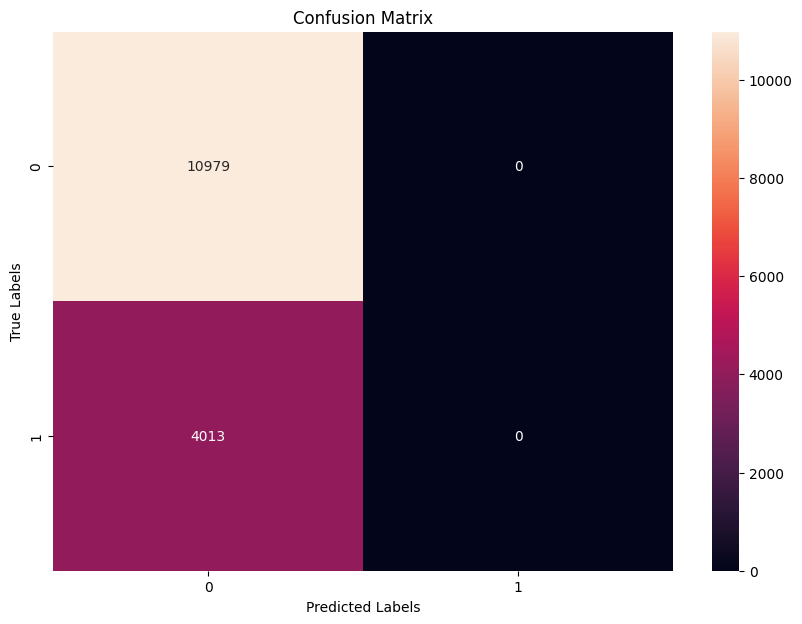

In [24]:
# Evaluation
# Load the trained model weights
load_model(model_LSTM_BERT, "drive/MyDrive/fnc-1/weights/lstm_bert_weights2.pth", device)

# Evaluation mode
model_LSTM_BERT.eval()

with torch.no_grad():
  predictions = model_LSTM_BERT(x_test)
  # Round the probabilities to 0 or 1
  predicted_classes = predictions.round().cpu()

  # Convert to numpy array
  if isinstance(predicted_classes, torch.Tensor):
    predicted_classes = predicted_classes.numpy()
  if isinstance(y_test, torch.Tensor):
    y_test = y_test.cpu().numpy()

  # Classification report, confusion matrix, and accuracy
  print("Classification Report:\n", classification_report(y_test, predicted_classes))
  print("Confusion Matrix:\n", confusion_matrix(y_test, predicted_classes))
  accuracy = accuracy_score(y_test, predicted_classes)
  print(f"Accuracy: {accuracy:.4f}")

  # Plot the confusion matrix
  conf_matrix = confusion_matrix(y_test, predicted_classes)
  plt.figure(figsize=(10, 7))
  sn.heatmap(conf_matrix, annot=True, fmt="g")
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.show()

### LSTM (Related or Unrelated) with TF-IDF

In [25]:
# Deep Learning LSTM Model - from practicals
class BinaryClassificationLSTM(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, num_layers=1, bidirectional=True):
    super(BinaryClassificationLSTM, self).__init__()

    self.rnn = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=hidden_dim,
      num_layers=num_layers,
      bidirectional=bidirectional,
      batch_first=True
    )
    self.drop = nn.Dropout(p=0.5)

    num_directions = 2 if bidirectional else 1
    self.fc = nn.Linear(num_directions * hidden_dim, 1)

  def forward(self, x):
    x = x.unsqueeze(1)

    output, (hn, cn) = self.rnn(x)

    last_output = output[:, -1, :]

    last_output = self.drop(last_output)
    last_output = self.fc(last_output)

    return torch.sigmoid(torch.squeeze(last_output, 1))

# Define the train variables
embedding_dim = all_tfidf.shape[1] # Since tf-idf
hidden_dim = 64

# Initialize the model
model_LSTM_TFIDF = BinaryClassificationLSTM(embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)


Layers:
	LSTM(18109, 64, batch_first=True, bidirectional=True)
	Dropout(p=0.5, inplace=False)
	Linear(in_features=128, out_features=1, bias=True)


In [26]:
# Train the LSTM model
# Convert data to torch tensors
x_LSTM = torch.tensor(all_tfidf.todense(), dtype=torch.float32).to(device)
y_LSTM = torch.tensor(df_q2["Stance"].values, dtype=torch.float32).to(device)

# Split 70% for training, 20% for testing and 10% for validation
x_train, x_test, y_train, y_test = train_test_split(x_LSTM, y_LSTM, test_size=0.3, random_state=4)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1/3, random_state=4)

# Convert data into tensors
def to_tensor(data):
  if isinstance(data, np.ndarray):
    return torch.tensor(data, dtype=torch.float32)
  elif isinstance(data, pd.Series) or isinstance(data, pd.DataFrame):
    return torch.tensor(data.values, dtype=torch.float32)
  else:
    return data.clone().detach().float()

to_tensor(x_train)
to_tensor(x_val)
to_tensor(x_test)
to_tensor(y_train)
to_tensor(y_val)
to_tensor(y_test)

# Define the loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model_LSTM_TFIDF.parameters(), lr=0.001)

# Perform the main training loop
num_epochs = 100
for epoch in range(num_epochs):
  model_LSTM_TFIDF.train()

  # Forward pass on the training set
  outputs_train = model_LSTM_TFIDF(x_train)
  print(outputs_train.shape)
  loss_train = criterion(outputs_train, y_train)

  # Backward and optimize
  optimizer.zero_grad()
  loss_train.backward()
  optimizer.step()

  # Enter evaluation mode
  model_LSTM_TFIDF.eval()
  with torch.no_grad():
    outputs_val = model_LSTM_TFIDF(x_val)
    loss_val = criterion(outputs_val, y_val)

  print(f'Epoch [{epoch+1}/{num_epochs}], Loss (Train): {loss_train.item():.4f}, Loss (Validation): {loss_val.item():.4f}')

# Save the model
save_model(model_LSTM_TFIDF, "drive/MyDrive/fnc-1/weights/lstm_tfidf_weights2.pth")


torch.Size([23320])
Epoch [1/100], Loss (Train): 0.7107, Loss (Validation): 0.7056
torch.Size([23320])
Epoch [2/100], Loss (Train): 0.7056, Loss (Validation): 0.7007
torch.Size([23320])
Epoch [3/100], Loss (Train): 0.7007, Loss (Validation): 0.6959
torch.Size([23320])
Epoch [4/100], Loss (Train): 0.6958, Loss (Validation): 0.6912
torch.Size([23320])
Epoch [5/100], Loss (Train): 0.6911, Loss (Validation): 0.6865
torch.Size([23320])
Epoch [6/100], Loss (Train): 0.6863, Loss (Validation): 0.6819
torch.Size([23320])
Epoch [7/100], Loss (Train): 0.6818, Loss (Validation): 0.6773
torch.Size([23320])
Epoch [8/100], Loss (Train): 0.6770, Loss (Validation): 0.6726
torch.Size([23320])
Epoch [9/100], Loss (Train): 0.6725, Loss (Validation): 0.6681
torch.Size([23320])
Epoch [10/100], Loss (Train): 0.6679, Loss (Validation): 0.6634
torch.Size([23320])
Epoch [11/100], Loss (Train): 0.6634, Loss (Validation): 0.6588
torch.Size([23320])
Epoch [12/100], Loss (Train): 0.6586, Loss (Validation): 0.6542
t

Model loaded from drive/MyDrive/fnc-1/weights/lstm_tfidf_weights2.pth
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.97      0.88     10975
         1.0       0.82      0.32      0.46      4017

    accuracy                           0.80     14992
   macro avg       0.81      0.65      0.67     14992
weighted avg       0.80      0.80      0.77     14992

Confusion Matrix:
 [[10689   286]
 [ 2722  1295]]
Accuracy: 0.7994


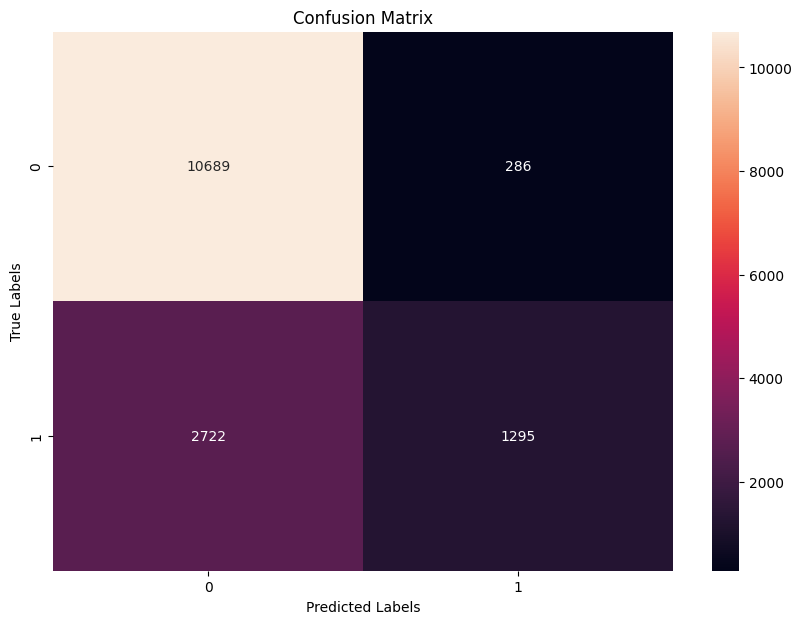

In [27]:
# Evaluation
# Load the trained model weights
load_model(model_LSTM_TFIDF, "drive/MyDrive/fnc-1/weights/lstm_tfidf_weights2.pth", device)

# Evaluation mode
model_LSTM_TFIDF.eval()

with torch.no_grad():
  predictions = model_LSTM_TFIDF(x_test)
  # Round probabilities to 0 or 1
  predicted_classes = predictions.round().cpu()

  # Convert to numpy array
  if isinstance(predicted_classes, torch.Tensor):
    predicted_classes = predicted_classes.numpy()
  if isinstance(y_test, torch.Tensor):
    y_test = y_test.cpu().numpy()

  # Classification report, confusion matrix, and accuracy
  print("Classification Report:\n", classification_report(y_test, predicted_classes))
  print("Confusion Matrix:\n", confusion_matrix(y_test, predicted_classes))
  accuracy = accuracy_score(y_test, predicted_classes)
  print(f"Accuracy: {accuracy:.4f}")

  # Plot the confusion matrix
  conf_matrix = confusion_matrix(y_test, predicted_classes)
  plt.figure(figsize=(10, 7))
  sn.heatmap(conf_matrix, annot=True, fmt="g")
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.show()


## Agree/Disagree/Discuss Classification (Question 2b)

In [28]:
# Adjust y stances in a new df, into related only (agree/disagree/discuss) for training
df_q2b = df_trans.copy(deep = True)

# Remove all stances that are unrelated
df_q2b = df_q2b[df_q2b["Stance"] != 3]

# Agree = 0, Disagree = 1, Discuss = 2

# Perform TF-IDF
#BERT_features = BERT(df_q2b)
df_tfidf = df_q2b.copy(deep = True)
df_tfidf["combined"] = df_tfidf["Headline"] + " " + df_tfidf["articleBody"]
x = df_tfidf["combined"]
all_tfidf = tfidf.fit_transform(x.values.astype("U"))

In [29]:
# Deep Learning Model
class MultiClassLSTM(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, num_classes=3, num_layers=1, bidirectional=True):
    super(MultiClassLSTM, self).__init__()

    self.rnn = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=hidden_dim,
      num_layers=num_layers,
      bidirectional=bidirectional,
      batch_first=True
    )
    self.drop = nn.Dropout(p=0.5)

    num_directions = 2 if bidirectional else 1
    # Define the output layer with 3 classes
    self.fc = nn.Linear(num_directions * hidden_dim, num_classes)

  def forward(self, x):
    output, (hn, cn) = self.rnn(x)

    last_output = output[:, -1, :]

    last_output = self.drop(last_output)
    last_output = self.fc(last_output)

    return F.log_softmax(last_output, dim=1)

# Define the train variables
embedding_dim = all_tfidf.shape[1] # Since TF-IDF
hidden_dim = 64
num_classes = 3  # The three classes

# Define the model
model_multi = MultiClassLSTM(embedding_dim=embedding_dim, hidden_dim=hidden_dim, num_classes=num_classes).to(device)


Layers:
	LSTM(17521, 64, batch_first=True, bidirectional=True)
	Dropout(p=0.5, inplace=False)
	Linear(in_features=128, out_features=3, bias=True)


In [30]:
# Train the multi-LSTM model
x_LSTM_multi = torch.tensor(all_tfidf.todense(), dtype=torch.float32).unsqueeze(1).to(device)
y_LSTM_multi = torch.tensor(df_q2b["Stance"].values, dtype=torch.long).to(device)

# Split 70% for training, 20% for testing and 10% for validation
x_train, x_test, y_train, y_test = train_test_split(x_LSTM_multi, y_LSTM_multi, test_size=0.3, random_state=4)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1/3, random_state=4)

# Define the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_multi.parameters(), lr=0.001)

# Perform the main training loop
num_epochs = 100
for epoch in range(num_epochs):
  model_multi.train()

  # Forward pass on the training set
  outputs_train = model_multi(x_train)
  loss_train = criterion(outputs_train, y_train)

  # Backward and optimize
  optimizer.zero_grad()
  loss_train.backward()
  optimizer.step()

  # Enter validation mode
  model_multi.eval()
  with torch.no_grad():
    outputs_val = model_multi(x_val)
    loss_val = criterion(outputs_val, y_val)

  print(f'Epoch [{epoch+1}/{num_epochs}], Loss (Train): {loss_train.item():.4f}, Loss (Validation): {loss_val.item():.4f}')

# Save the model
save_model(model_multi, "drive/MyDrive/fnc-1/weights/lstm_multi_weights2.pth")


Epoch [1/100], Loss (Train): 1.1083, Loss (Validation): 1.0991
Epoch [2/100], Loss (Train): 1.0978, Loss (Validation): 1.0899
Epoch [3/100], Loss (Train): 1.0888, Loss (Validation): 1.0808
Epoch [4/100], Loss (Train): 1.0784, Loss (Validation): 1.0717
Epoch [5/100], Loss (Train): 1.0689, Loss (Validation): 1.0627
Epoch [6/100], Loss (Train): 1.0592, Loss (Validation): 1.0536
Epoch [7/100], Loss (Train): 1.0492, Loss (Validation): 1.0444
Epoch [8/100], Loss (Train): 1.0393, Loss (Validation): 1.0352
Epoch [9/100], Loss (Train): 1.0292, Loss (Validation): 1.0258
Epoch [10/100], Loss (Train): 1.0192, Loss (Validation): 1.0162
Epoch [11/100], Loss (Train): 1.0091, Loss (Validation): 1.0064
Epoch [12/100], Loss (Train): 0.9981, Loss (Validation): 0.9965
Epoch [13/100], Loss (Train): 0.9876, Loss (Validation): 0.9864
Epoch [14/100], Loss (Train): 0.9762, Loss (Validation): 0.9760
Epoch [15/100], Loss (Train): 0.9653, Loss (Validation): 0.9655
Epoch [16/100], Loss (Train): 0.9535, Loss (Valid

Model loaded from drive/MyDrive/fnc-1/weights/lstm_multi_weights2.pth
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.64      0.67      1096
           1       0.53      0.15      0.24       255
           2       0.84      0.92      0.88      2678

    accuracy                           0.80      4029
   macro avg       0.69      0.57      0.59      4029
weighted avg       0.78      0.80      0.78      4029

Confusion Matrix:
 [[ 706   24  366]
 [ 124   39   92]
 [ 197   11 2470]]
Accuracy: 0.7980


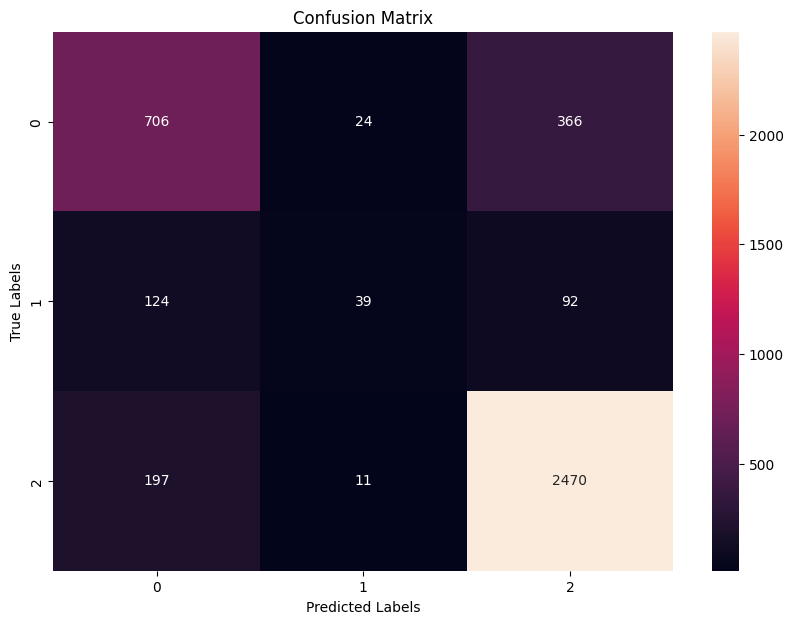

In [31]:
# Evaluation
# Load the saved model weights
load_model(model_multi, "drive/MyDrive/fnc-1/weights/lstm_multi_weights2.pth", device)

# Evaluation mode
model_multi.eval()
with torch.no_grad():
  predictions = model_multi(x_test)
  predicted_classes = torch.argmax(predictions, dim=1).cpu()

  y_test = y_test.cpu()

  # Compute the classification report, confusion matrix, and accuracy
  print("Classification Report:\n", classification_report(y_test, predicted_classes))
  print("Confusion Matrix:\n", confusion_matrix(y_test, predicted_classes))
  accuracy = accuracy_score(y_test, predicted_classes)
  print(f"Accuracy: {accuracy:.4f}")

  # Plot the confusion matrix
  conf_matrix = confusion_matrix(y_test, predicted_classes)
  plt.figure(figsize=(10, 7))
  sn.heatmap(conf_matrix, annot=True, fmt="g")
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.show()


### Combine the LSTM and Multi-LSTM Models

In [32]:
# Create the pipeline for input (as a df)
# Load the model weights
load_model(model_LSTM_BERT, "drive/MyDrive/fnc-1/weights/lstm_bert_weights2.pth", device)
load_model(model_multi, "drive/MyDrive/fnc-1/weights/lstm_multi_weights2.pth", device)

# Pre-process the data as before
def preprocess(df_input):
  df_process = df_input.copy()

  # Clean the columns
  for col in df_process.columns[:2]:
    clean_column(col)

  # Lemmatize the text within the columns
  for col in df_process.columns[:2]:
    # Due to previous error
    df_process.loc[:, col] = df_process[col].apply(lemmatize)

  # Remove stopwords
  for col in df_process.columns[:2]:
    df_process.loc[:, col] = df_process[col].apply(remove_stopwords)

  return df_process

# Pass through the BERT transformer
def complete_bert(df_input):
  df_process = df_input.copy()
  # Apply the BERT transformer for the models
  BERT_input = BERT(df_process)
  return BERT_input

# Classify the article
def classify_article(df_input, BERT_input):
  # Store the predictions into a list
  final_predictions = []
  # Iterate through each row from the input
  for idx, row in df_input.iterrows():
    # Convert to a tensor and add the batch dimension as previously
    BERT_tensor = to_tensor(BERT_input).unsqueeze(0).to(device)

    # Pass the data through the binary classifier LSTM model
    model_LSTM_BERT.eval()
    with torch.no_grad():
      prediction = model_LSTM_BERT(BERT_tensor).round()

    # Unrelated = 0, Related = 1
    if prediction.item() == 1:
      # Pass the data through the multiclass classifier LSTM model
      model_multi.eval()
      with torch.no_grad():
        prediction2 = model_multi(BERT_tensor)
        # Add the predictions (in their original form) to the list
        _, predicted_class = torch.max(prediction2, dim=1)
        prediction2.append(predicted_class.item())
    else:
      # Add the prediction to the list
      final_predictions.append("unrelated")

  return final_predictions

Model loaded from drive/MyDrive/fnc-1/weights/lstm_bert_weights2.pth
Model loaded from drive/MyDrive/fnc-1/weights/lstm_multi_weights2.pth


In [ ]:
# Test complete model performance
# Prepare the test set
complete_test_stances = pd.read_csv("drive/MyDrive/fnc-1/competition_test_stances.csv")
complete_test_bodies = pd.read_csv("drive/MyDrive/fnc-1/competition_test_bodies.csv")

complete_test = complete_test_stances.merge(complete_test_bodies, on="Body ID", how="inner")
complete_test = complete_test[["Headline", "articleBody", "Stance"]]
# complete_test = complete_test.head(100)
# Use 5000 for the test set
complete_test = complete_test.sample(n=5000, random_state=4110)

# Define the input data and ground truth
complete_test_x = complete_test[["Headline", "articleBody"]]
complete_test_y = complete_test[["Stance"]]

# Preprocess (lemmatization, remove stopwords, apply BERT transformer)
process_x = preprocess(complete_test_x)
bert_x = complete_bert(process_x)
# Classify the test set
predicted_labels = classify_article(process_x, bert_x)

# Compute the classification report, confusion matrix, and accuracy
print("Classification Report:\n", classification_report(complete_test_y, predicted_labels))
print("Confusion Matrix:\n", confusion_matrix(complete_test_y, predicted_labels))
accuracy = accuracy_score(complete_test_y, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Plot the confusion matrix
conf_matrix = confusion_matrix(complete_test_y, predicted_labels)
plt.figure(figsize=(10, 7))
sn.heatmap(conf_matrix, annot=True, fmt="g")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

plt.figure(figsize=(10, 7))
plt.roc_curve(complete_test_y, predicted_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()